# Credit Card Fraud Detection
Dataset: `credit_card_fraud_dataset.csv`

**Goal:** Load, preprocess, train baseline models (Logistic Regression & Random Forest), evaluate with proper metrics (not just accuracy). Interpretation (feature influence, false positive/negative discussion).

Columns used:
- TransactionDate (derive TransactionHour)
- Amount
- TransactionType (categorical)
- Location (categorical)
- IsFraud (target)

## Imports

In [42]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score, roc_curve, precision_recall_curve)
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

## Load Dataset

In [43]:
# Adjust path if notebook is not in the same folder
DATA_PATH = Path('/content/credit_card_fraud_dataset.csv')
df = pd.read_csv(DATA_PATH)
print(f"Rows: {len(df)}  | Columns: {df.shape[1]}")
df.head()

Rows: 100000  | Columns: 7


,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


## Basic Exploration

In [44]:
# Check types and first few entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [45]:
# Basic statistics for numeric columns of interest
print(df[['Amount']].describe())

              Amount
count  100000.000000
mean     2497.092666
std      1442.415999
min         1.050000
25%      1247.955000
50%      2496.500000
75%      3743.592500
max      4999.770000


In [46]:
# Fraud distribution
fraud_counts = df['IsFraud'].value_counts().sort_index()
print("\nFraud class distribution:")
print(fraud_counts)
print(f"Fraud rate: {df['IsFraud'].mean()*100:.3f}%")


Fraud class distribution:
IsFraud
0    99000
1     1000
Name: count, dtype: int64
Fraud rate: 1.000%


In [47]:
# Unique categories (to ensure they're manageable for one-hot encoding)
print('\nUnique Transaction Types:', df['TransactionType'].nunique())
print('Unique Locations:', df['Location'].nunique())


Unique Transaction Types: 2
Unique Locations: 10


## Feature Engineering
We only derive `TransactionHour` from `TransactionDate`.

In [48]:
# Convert timestamp and extract hour
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionHour'] = df['TransactionDate'].dt.hour

df[['TransactionDate', 'TransactionHour']].head()

,TransactionDate,TransactionHour
0,2024-04-03 14:15:35.462794,14
1,2024-03-19 13:20:35.462824,13
2,2024-01-08 10:08:35.462834,10
3,2024-04-13 23:50:35.462850,23
4,2024-07-12 18:51:35.462858,18


## Select Features & Handle Missing Values
- No missing values expected.
- Chosen features: Amount, TransactionHour, TransactionType, Location.
- Target: IsFraud.

In [49]:
print('Missing values per column:')
print(df.isna().sum())

feature_cols = ['Amount', 'TransactionHour', 'TransactionType', 'Location']
X = df[feature_cols].copy()
y = df['IsFraud']

Missing values per column:
TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
TransactionHour    0
dtype: int64


In [50]:
print('\nFeature sample:')
X.head()


Feature sample:


,Amount,TransactionHour,TransactionType,Location
0,4189.27,14,refund,San Antonio
1,2659.71,13,refund,Dallas
2,784.00,10,purchase,New York
3,3514.40,23,purchase,Philadelphia
4,369.07,18,purchase,Phoenix


## Train/Test Split (Stratified)
Stratification preserves rare fraud class proportion in both sets.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train size: {len(X_train)}  Test size: {len(X_test)}")
print('Fraud rate train:', y_train.mean())
print('Fraud rate test :', y_test.mean())

Train size: 75000  Test size: 25000
Fraud rate train: 0.01
Fraud rate test : 0.01


## Preprocessing (Scaling + One-Hot)
Numeric: Amount, TransactionHour (scaled)
Categorical: TransactionType, Location (one-hot encoded)

Class imbalance handling:
- Use `class_weight="balanced"` in Logistic Regression.
- Use `class_weight="balanced"` in Random Forest. (Helps model pay attention to rare fraud cases.)

In [52]:
numeric_features = ['Amount', 'TransactionHour']
categorical_features = ['TransactionType', 'Location']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

logreg_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42))
])

rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

## Train Models

In [53]:
logreg_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
print('Models trained.')

Models trained.


## Evaluation Utilities
We evaluate:
- Accuracy
- Confusion matrix (numbers + heatmap)
- Classification report (precision, recall, F1)
- ROC-AUC
- PR-AUC (Average Precision) — important for imbalanced data

Also evaluate a DummyClassifier (predict majority class) as baseline.

In [73]:
def evaluate_model(name, model, X_test, y_test, plot_cm=True):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # Fallback if no predict_proba
        y_prob = None

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)
        print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC (Avg Precision): {pr_auc:.4f} \n")

    if plot_cm:
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    return cm

## Run Model Evaluations

### Logistic Regression

=== Logistic Regression ===
Accuracy: 0.5675
Confusion Matrix (rows=true, cols=pred):
[[14087 10663]
 [  150   100]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9895    0.5692    0.7227     24750
           1     0.0093    0.4000    0.0182       250

    accuracy                         0.5675     25000
   macro avg     0.4994    0.4846    0.3704     25000
weighted avg     0.9797    0.5675    0.7156     25000

ROC-AUC: 0.4661 | PR-AUC (Avg Precision): 0.0094 



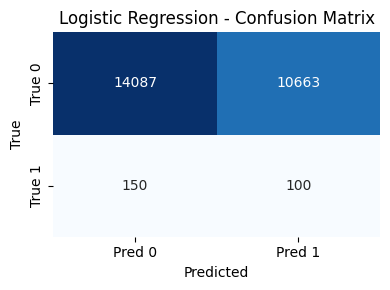

In [74]:
cm_log = evaluate_model('Logistic Regression', logreg_pipeline, X_test, y_test)

### Random Forest

=== Random Forest ===
Accuracy: 0.9879
Confusion Matrix (rows=true, cols=pred):
[[24696    54]
 [  249     1]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9900    0.9978    0.9939     24750
           1     0.0182    0.0040    0.0066       250

    accuracy                         0.9879     25000
   macro avg     0.5041    0.5009    0.5002     25000
weighted avg     0.9803    0.9879    0.9840     25000

ROC-AUC: 0.5057 | PR-AUC (Avg Precision): 0.0105 



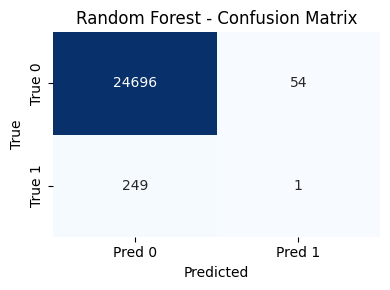

In [75]:
cm_rf  = evaluate_model('Random Forest', rf_pipeline, X_test, y_test)

## Store Artifacts for Interpretation
We capture:
- Logistic regression coefficients
- Random forest feature importances

In [76]:
# Get feature names after preprocessing
ohe = logreg_pipeline.named_steps['prep'].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + ohe_feature_names

# Logistic regression coefficients
log_coeffs = logreg_pipeline.named_steps['model'].coef_[0]
log_coef_df = pd.DataFrame({'feature': all_feature_names, 'log_coef': log_coeffs})\
                .sort_values('log_coef', ascending=False)

# Random forest feature importances (same transformed space)
rf_importances = rf_pipeline.named_steps['model'].feature_importances_
rf_imp_df = pd.DataFrame({'feature': all_feature_names, 'rf_importance': rf_importances})\
               .sort_values('rf_importance', ascending=False)

In [77]:
display(log_coef_df.head(10))

,feature,log_coef
12,Location_San Diego,0.202217
8,Location_New York,0.192700
11,Location_San Antonio,0.109282
3,TransactionType_refund,0.044211
5,Location_Dallas,0.033743
10,Location_Phoenix,0.029790
0,Amount,0.026630
1,TransactionHour,-0.011897
2,TransactionType_purchase,-0.050811
6,Location_Houston,-0.074827


In [78]:
display(rf_imp_df.head(10))

,feature,rf_importance
0,Amount,0.649778
1,TransactionHour,0.277577
2,TransactionType_purchase,0.006544
3,TransactionType_refund,0.006311
11,Location_San Antonio,0.006248
4,Location_Chicago,0.006160
6,Location_Houston,0.006135
12,Location_San Diego,0.006122
8,Location_New York,0.006028
10,Location_Phoenix,0.005973


## Interpret the Results